# Game Class

The PATH_GAME object will recieve following items to be initialized:
- Grid size of the game as a tuple with form of rows and columns
- Number's distribution that would fill the grid
- Mode of the Game ( 1 : the cost will be the neighbours value, 2 : the cost will be difference between current and neighbour value)
- Desired start point in the grid as a form of list
- Desired end point in the grid as a form of list
- Game type which sets the approach of the game. it can be dijkstra or the personal naive implementation
- KWARGS: for number's distribution, such as minimum and maximum and etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class PATH_GAME:
    
    # Creating a game object for getting parameters of the game from the user
    def __init__(self, grid_size, distribution, mode, start, end, game_type, **kwargs):
        """Possible distributions: normal, randint, lognormal, poisson, chisquare"""
        kwargs = {'minimum':0,'maximum':10,'mean':10,'scale': 10,'lam':10,'df':2}
        # kwargs are for different distributaion of numbers in the grid
        
        self.distr = getattr(np.random,distribution)
        
        # filling the grids with random numbers
        if distribution == 'normal':
            self.Game = self.distr(loc = kwargs['mean'], scale = kwargs['scale'],size = grid_size)
        elif distribution == 'lognormal':
            self.Game = self.distr(size = grid_size)        
        elif distribution == 'randint':
            self.Game = self.distr(kwargs['minimum'],kwargs['maximum'],size = grid_size)
        elif distribution == 'poisson':
            self.Game = self.distr(kwargs['lam'],size = grid_size)
        else:
            self.Game = self.distr(kwargs['df'],size = grid_size)
        
        
        self.start_node = start # coordintation of the starting node in the grid
        self.end_node = end # coordination of the ending node in the grid
        self.mode = mode
        self.visited = [] # storing visited nodes in the grid for future visualization
        self.cost_list = [] # cost list contains cost for each cells
        self.play_ground = np.arange(self.Game.size).reshape(self.Game.shape[0],-1).astype('object') 
        # play ground is a numpy array for naive approach which is filled by infinite numbers
        
        self.play_ground[:] = np.Inf 
        
        # selecting which approach we are using in the game. dijkstra or naive approach are allowed in this stage.
        # starting game can be included in constructor method or it can be used as an extra method of the class
        if game_type == 'dijkstra':
            self.dijkstra(start, end)
        elif game_type == 'naive':
            self.start_game()
        else:
            print('Invalid game approach')
        
        # visualization can be done while creating the game or it can be used as a separate method
        #self.visualize()

    def cost_func(self,current,neighbour):
        
        # cost function is detemined by the mode of the game. in mode 1, the neighbour cell number is important
        # and in mode 2, the difference is important
        
        if self.mode == 1:
            return self.play_ground[neighbour[0],neighbour[1]]      
        elif self.mode == 2:
            return abs(self.play_ground[current[0],current[1]] - self.play_ground[neighbour[0],neighbour[1]])

    
    def visualize(self):
        
        # spliting visited cells in two different arrays for using in the 3d plot visualization
        x = []
        y = []
        for i,j in self.visited:
            x.append(i)
            y.append(j)
        z = 0
        dx = dy = 0.5
        dz = self.cost_list

        
        fig = plt.figure(figsize=(15, 8))
        fig.suptitle('Possible Shortest Path: {}'.format(sum(self.cost_list)))
        
        # 3d plot of the visited cells, the height of each bar represent the cells cost number
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.bar3d(x, y, z, dx, dy, dz, shade=True)
        ax1.set_title('Path Cost')
        
        # making a grid for path visualization
        ax2 = fig.add_subplot(122)
        data = np.zeros(self.Game.shape)
        for cell in self.visited:
            data[cell[0],cell[1]] = 1
        
        ax2.matshow(data, cmap = 'summer')
        
        # filling the mat grid with numbers of each cell that has been randomly generated
        if self.Game.dtype == 'int':
            for (i, j), z in np.ndenumerate(self.Game):
                ax2.text(j, i, '{}'.format(z), ha='center', va='center')
        else:
            for (i, j), z in np.ndenumerate(self.Game):
                ax2.text(j, i, format(z,'.0f'), ha='center', va='center')
        ax2.axes.xaxis.set_visible(False)
        ax2.axes.yaxis.set_visible(False)
        ax2.set_title('Game Grid')
        plt.show()
    
    def start_game(self):
        
        # This is the first step of naive approach in which we limit the grid to a smaller grid in which
        # starting an ending are on the corners.
        
        self.visited = []
        self.cost_list = [self.Game[self.start_node[0],self.start_node[1]]]
        a1 = min(self.start_node[0],self.end_node[0])
        a2 = max(self.start_node[0],self.end_node[0])
        b1 = min(self.start_node[1],self.end_node[1])
        b2 = max(self.start_node[1],self.end_node[1])
        for i in range(a1, a2 + 1):
            for j in range(b1, b2 + 1):
                self.play_ground[i,j] = self.Game[i,j]
        
        # the direction of the game will be evaluated by the position of the starting and ending nodes. this is
        # for avoiding to get confused for the main purpose of the game.
        if self.start_node[0] <= self.end_node[0] and self.start_node[1] <= self.end_node[1]:
            direct = 'LR'
        elif self.start_node[0] > self.end_node[0] and self.start_node[0] < self.end_node[0]:
            direct = 'LL'
        elif self.start_node[0] <= self.end_node[0] and self.start_node[1] >= self.end_node[1]:
            direct = 'UR'
        else:
            direct = 'UL'
        
        # after limiting the grid and identifying the direction, we will find the bset path regards to the mode
        self.best_path(self.start_node, self.end_node, direct)
        
        self.cost_mean = np.array(self.cost_list).mean()
        self.cost_var = np.array(self.cost_list).var()
        self.result = sum(self.cost_list)
        return self.result
    
    
    def find_neighbour(self,cell,direction = None):
        
        # finding cell's nighbour based on theri position and the approach which is being used in the game.
        # for naive approach we will used a direction (which gives were are the starting and ending nodes
        # are located respectively). 
        neighbours_list = []
        direction_list = {'UL':([-1, 0],[-1, 0]),
                          'UR':([0 , 1],[-1, 0]),
                          'LL':([-1, 0],[ 0, 1]),
                          'LR':([0 , 1],[ 0, 1])
                         }
        # for dijkstra approach direction would be none
        if direction == None:
            for i in [-1,0,1]:
                for j in [-1,0,1]:
                    if (i * j == 1 or i * j == -1) or (i == 0 and j == 0):
                        continue
                    try:
                        neighbour = [cell[0]+i,cell[1]+j]
                        assert self.Game.shape[0] > cell[0]+i >= 0 and self.Game.shape[1] > cell[1]+j >= 0
                        neighbours_list.append(neighbour)                
                    except:
                        continue
            return neighbours_list
        
        # for naive approach direction is mandtory    
        else:
            for i in direction_list[direction][0]:
                for j in direction_list[direction][1]:
                    if (i * j == 1 or i * j == -1) or (i == 0 and j == 0):
                        continue
                    try:
                        neighbour = [cell[0]+i,cell[1]+j]
                        assert self.Game.shape[0] > cell[0]+i >= 0 and self.Game.shape[1] > cell[1]+j >= 0
                        neighbours_list.append(neighbour)                
                    except:
                        continue
            return neighbours_list
    
    def best_path(self,starting,ending,direction):
        
        # a recursive function which will execute until we reach to the ending cell
        direct = direction
        self.visited.append(starting)
        adjacent = self.find_neighbour(starting, direct)
        
        # ending criteria is starting at the ending point
        if starting == ending:
            return self.visited
        
        # if we are in neighbour of ending node, no matter the cost we will go there
        elif ending in adjacent:
            next_cord = ending
            next_value = self.cost_func(starting, ending)
        else:
            
            # we continue examining each cell to see which one has lower cost, then we will chose it as the next destination
            next_cord = []
            next_value = np.Inf
            for cell in adjacent:
                if self.cost_func(starting, cell) < next_value:
                    next_cord = cell
                    next_value = self.cost_func(starting, cell)
        # appending the best cell to visited cells and adding the cost of it to a cost list for future visualization
        self.cost_list.append(next_value)
        return self.best_path(next_cord, ending,direct) 
    
    def dijkstra(self, starting, ending):
        
        # in this approach we will generate an adjacent array to compute the cost value from every node to
        # its neighbours. so we will transform the grids coordinate to a single number. source is for starting
        # point and target is for ending point
        
        self.source = starting[0] * self.Game.shape[0]  + starting[1]
        self.target = ending[0] * self.Game.shape[0]  + ending[1]
        
        # in this dictionary we will keep the record that from which cell we have reached to another cell
        self.parents = {}
        self.graph = {} # the graph dictionary of the grid. in this dictionary we will keep the cells neighbour and their cost
        self.cost = {} 
        
        # in this approach we will not limit the game to starting and ending cells
        self.play_ground = self.Game
        
        # filling the graph dictionary with approprate numbers regards to self.Game which is the base grid of the game
        for rows in range(self.Game.shape[0]):
            for cols in range(self.Game.shape[1]):
                code = rows * self.Game.shape[0] + cols
                self.graph[code] = {}
                if starting == [rows,cols]:
                    self.cost[code] = 0
                else:
                    self.cost[code] = np.Inf
                for cell in self.find_neighbour([rows,cols]):
                    cell_code = cell[0] * self.Game.shape[0] + cell[1]
                    self.graph[code][cell_code] = self.cost_func([rows,cols], [cell[0],cell[1]])
        
        # iterating over all cells and find the cost from each cell to neighbours. this iteration 
        # would last until we reach to the final cell or the ending cell
        nextNode = self.source
        while nextNode != self.target:
            
            for neighbor in self.graph[nextNode]:               
                if self.graph[nextNode][neighbor] + self.cost[nextNode] < self.cost[neighbor]:                   
                    self.cost[neighbor] = self.graph[nextNode][neighbor] + self.cost[nextNode]                   
                    self.parents[neighbor] = nextNode                   
                del self.graph[neighbor][nextNode]              
            del self.cost[nextNode]           
            nextNode = min(self.cost, key=self.cost.get)
        
        # creating the path that a cell can reach to the ending point from the starting cell based on the
        # visited cells before
        node = self.target      
        backpath = [self.target]      
        path = []
        while node != self.source:          
            backpath.append(self.parents[node])       
            node = self.parents[node]
        for i in range(len(backpath)):     
            path.append(backpath[-i - 1])
        final = []
        final_cost = 0
        self.cost_list = []
        
        # creating final cost, cost_list for future visualization an analysis.
        for i in path:
            final.append([i // self.Game.shape[0], i % self.Game.shape[0]])
            self.cost_list.append(self.Game[i // self.Game.shape[0],i % self.Game.shape[0]])
            final_cost += self.Game[i // self.Game.shape[0],i % self.Game.shape[0]]

        if self.mode == 2:
            a = np.array(self.cost_list[:-1])
            b = np.array(self.cost_list[1:])
            
            final_cost = np.sum(np.abs(a-b))
            self.cost_list = np.abs(a-b)
 
            self.cost_list = np.append(self.cost_list,0)
        self.visited = final
        
        self.cost_mean = np.array(self.cost_list).mean()
        self.cost_var = np.array(self.cost_list).var()
        self.result = sum(self.cost_list)
        return self.result
        
           
    def to_be_visited(self):
        
        # an internal method for implementing dijkstra approach. in this method we will choose the next cell
        # based on the cost that they have around the current cell
        
        next_vertex = -100
        
        for index in range(self.number_of_vertices):
            if self.visited_and_distance[index][0] == 0 and (next_vertex < 0 or self.visited_and_distance[index][1] <= \
               self.visited_and_distance[next_vertex][1]):
                next_vertex = index
        return next_vertex

## Testing the game with Dijkstra's algorithm

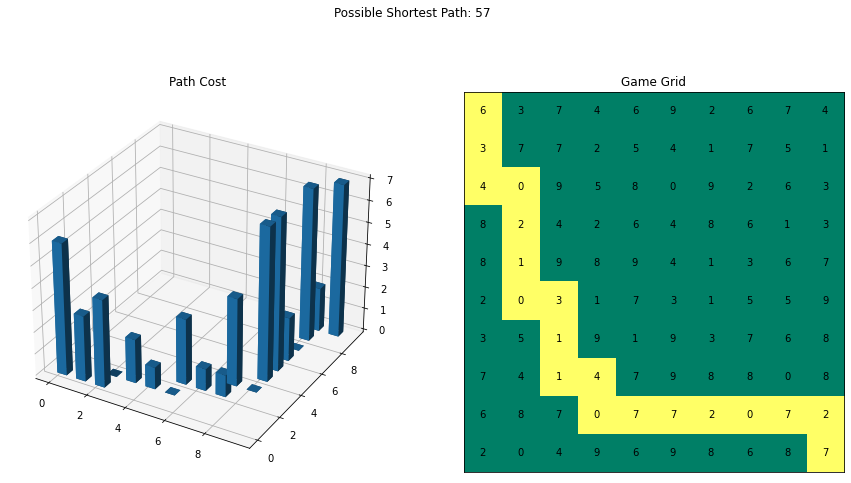

In [2]:
np.random.seed(42)
G = PATH_GAME((10,10),'randint',1,[0,0],[9,9], 'dijkstra')
G.visualize()

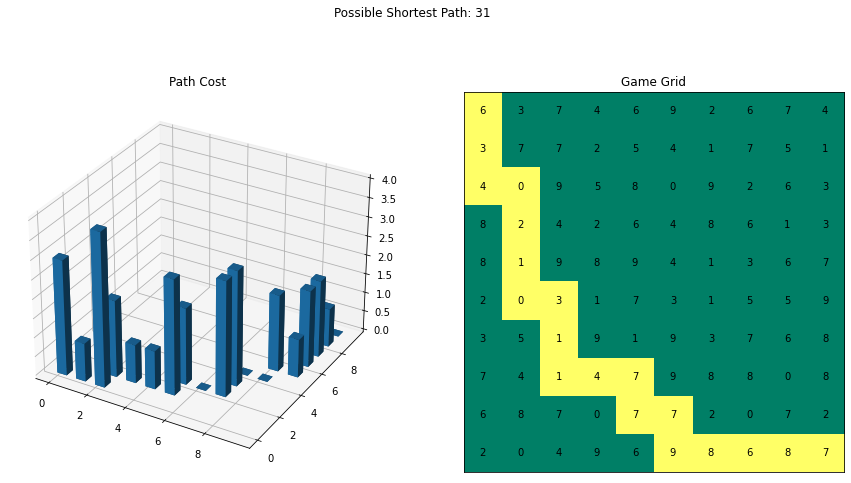

In [3]:
np.random.seed(42)
G = PATH_GAME((10,10),'randint',2,[0,0],[9,9], 'dijkstra')
G.visualize()

## Testing the game with proposed algorithm

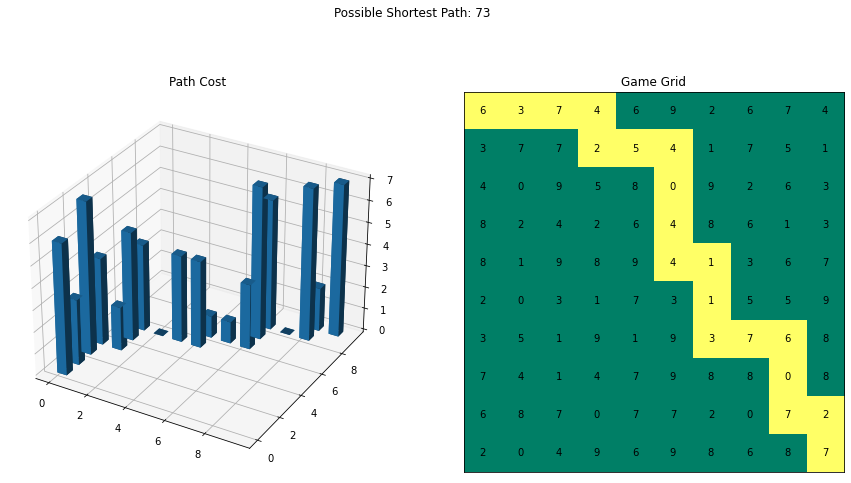

In [4]:
np.random.seed(42)
G = PATH_GAME((10,10),'randint',1,[0,0],[9,9], 'naive')
G.visualize()

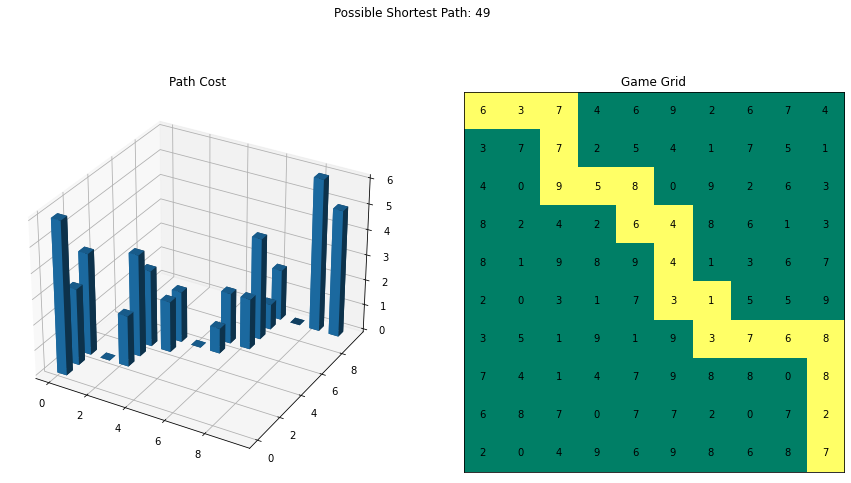

In [5]:
np.random.seed(42)
G = PATH_GAME((10,10),'randint',2,[0,0],[9,9], 'naive')
G.visualize()

## Analysing the game based on grid size, number's distribution, game approach and mode

In [6]:
def Game_analysis(measure, approach_eval = False, mode_eval = False, gridr = (10,10), distr = 'randint'):
    
    # This function takes a measure (which can be grid size or distribution) and then returns bar chart comparing
    # the measure with other factors. in the 'grid' measure the game would run from a (2,2) grid size to (20,20)
    # cell size and the total cost would be stored in a list. at the end the bar chart shows the trend of path
    # cost regards to the grid size increase. the measure 'distribution' is for trying different type of creating
    # grid numbers. aproach_eval input is for comparing dijkstra and naive algorithms beside the main measure.
    # mode_eval is for comparing two types of models beside the main measure.
    # we can also change the distribution for grids comparison and grid size for distribution's comparison.
    
    if measure == 'grid':
        fig = plt.figure(figsize=(7,7))
        ax1 = fig.add_subplot(111)
        fig1= plt.figure(figsize=(7,7))
        ax2 = fig1.add_subplot(111)
        fig2=plt.figure(figsize=(7,7))
        ax3 = fig2.add_subplot(111)
        ax1.set_title('Cost vs. Grid')
        ax2.set_title('Mean vs. Grid')
        ax1.set_xlabel('Grid Size')
        ax1.set_ylabel('Cost')      
        ax2.set_xlabel('Grid Size')
        ax2.set_ylabel('Cost')
        ax3.set_xlabel('Grid Size')
        ax3.set_ylabel('Cost')   
        ax3.set_title('Var vs. Grid')
        all_costs1 = []
        all_costs2 = []
        all_costs3 = []
        all_costs4 = []
        mean1 = []
        mean2 = []
        mean3 = []
        mean4 = []
        var1 = []
        var2 = []
        var3 = []
        var4 = []        
        x = []
        for i in range(2,21):
            G1 = PATH_GAME((i,i),distr,1,[0,0],[i-1,i-1],'dijkstra')
            G2 = PATH_GAME((i,i),distr,2,[0,0],[i-1,i-1],'dijkstra')
            G3 = PATH_GAME((i,i),distr,1,[0,0],[i-1,i-1],'naive')
            G4 = PATH_GAME((i,i),distr,2,[0,0],[i-1,i-1],'naive')

            all_costs1.append(G1.result)
            all_costs2.append(G2.result)
            all_costs3.append(G3.result)
            all_costs4.append(G4.result)
            
            mean1.append(G1.cost_mean)
            mean2.append(G2.cost_mean)
            mean3.append(G3.cost_mean)
            mean4.append(G4.cost_mean)
            
            var1.append(G1.cost_var)
            var2.append(G2.cost_var)
            var3.append(G3.cost_var)
            var4.append(G4.cost_var)
            
            x.append(i)
        
        w = 0.2
        
        ax1.bar(x, all_costs1, label='dijkstra, mode:1', color = 'b', width = w)
        ax2.plot(x, mean1, label = 'dijkstra, mode:1', color = 'b', marker = '^', linestyle = '-')
        ax3.plot(x, var1, label = 'dijkstra, mode:1', color = 'b', marker = '^', linestyle = '-')
        if approach_eval == True:
            ax1.bar(np.array(x) + 0.2 , all_costs3, label='naive, mode:1', color = 'r', width = w)
            ax2.plot(x, mean3, label = 'naive, mode:1', color = 'r', marker = '^', linestyle = '-')
            ax3.plot(x, var3, label = 'naive, mode:1', color = 'r', marker = '^', linestyle = '-')
            
        if mode_eval == True:
            ax1.bar(np.array(x) + 0.4, all_costs2, label='dijkstra, mode:2', color = 'g', width = w)
            ax2.plot(x, mean2, label = 'dijkstra, mode:2', color = 'g', marker = '^', linestyle = '-')
            ax3.plot(x, var2, label = 'dijkstra, mode:2', color = 'g', marker = '^', linestyle = '-')
        if approach_eval == True and mode_eval == True:
            ax1.bar(np.array(x) + 0.6, all_costs4, label='naive, mode:2', color = 'k', width = w)
            ax2.plot(x, mean4, label = 'naive, mode:2', color = 'k', marker = '^', linestyle = '-')
            ax3.plot(x, var4, label = 'naive, mode:2', color = 'k', marker = '^', linestyle = '-')
        
        fig1.legend()
        fig2.legend()
        
        
    elif measure == 'distribution':
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(111)
        dists = ['normal', 'randint', 'lognormal', 'poisson', 'chisquare']
        all_costs1 = []
        all_costs2 = []
        all_costs3 = []
        all_costs4 = []
        for dist in dists:
            G1 = PATH_GAME(gridr,dist,1,[0,0],[9,9],'dijkstra',minimum = 0, maximum = 10)
            G2 = PATH_GAME(gridr,dist,2,[0,0],[9,9],'dijkstra',minimum = 0, maximum = 10)
            G3 = PATH_GAME(gridr,dist,1,[0,0],[9,9],'naive',minimum = 0, maximum = 10)
            G4 = PATH_GAME(gridr,dist,2,[0,0],[9,9],'naive',minimum = 0, maximum = 10)
            all_costs1.append(G1.result)
            all_costs2.append(G2.result)
            all_costs3.append(G3.result)
            all_costs4.append(G4.result)
        w = 0.2
        ax1.bar([0,1,2,3,4],all_costs1,label='dijkstra, mode:1', color = 'b', width = w)
        if approach_eval == True:
            ax1.bar([0.2,1.2,2.2,3.2,4.2], all_costs3, label='naive, mode:1', color = 'r', width = w)
        if mode_eval == True:
            ax1.bar([0.4,1.4,2.4,3.4,4.4], all_costs2, label='dijkstra, mode:2', color = 'g', width = w)
        if approach_eval == True and mode_eval == True:
            ax1.bar([0.6,1.6,2.6,3.6,4.6], all_costs4, label='naive, mode:2', color = 'k', width = w)        
        
        
        
        ax1.set_xticks([0,1,2,3,4])
        ax1.set_xticklabels(dists)
        ax1.set_title('Cost vs. Distribution')
        ax1.set_xlabel('Distributions')
        ax1.set_ylabel('Cost')      
  

    fig.legend()

    results = (all_costs1,all_costs2,all_costs3,all_costs4)

    return results

%500 Increase in cost
%1600 Increase in cost
%400 Increase in cost
%4300 Increase in cost


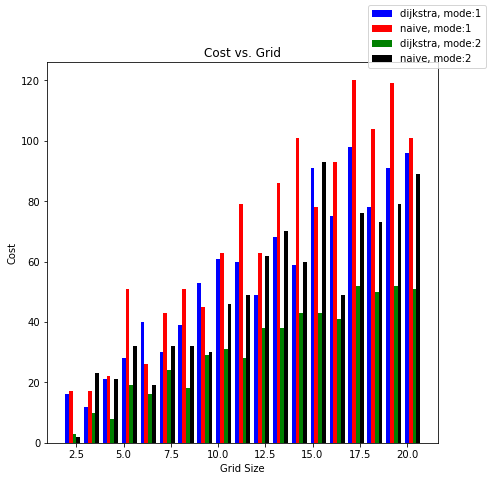

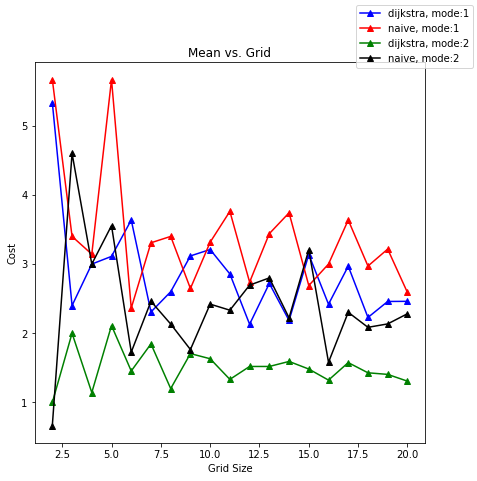

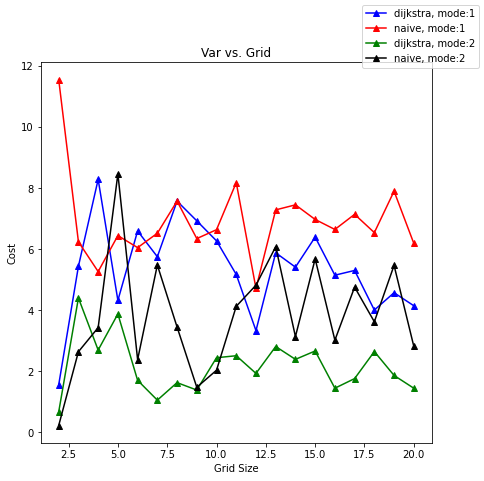

In [11]:
np.random.seed(30)
all_costs1,all_costs2,all_costs3,all_costs4 = Game_analysis('grid',True, True)
print('%{} Increase in cost'.format(int((all_costs1[-1] - all_costs1[0])/ all_costs1[0])*100))
print('%{} Increase in cost'.format(int((all_costs2[-1] - all_costs2[0])/ all_costs2[0])*100))
print('%{} Increase in cost'.format(int((all_costs3[-1] - all_costs3[0])/ all_costs3[0])*100))
print('%{} Increase in cost'.format(int((all_costs4[-1] - all_costs4[0])/ all_costs4[0])*100))

As it can be seen on the plot, the cost is getting higher by increasing the number of cells in the game. Also dijkstra algorithm is performing better than naive approach in almost every single comparison. The following diagram shows the grid size effect with lognormal distribution. 

%500 Increase in cost
%1600 Increase in cost
%400 Increase in cost
%4300 Increase in cost


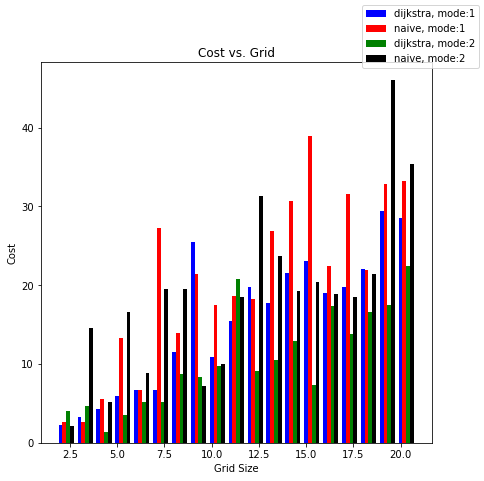

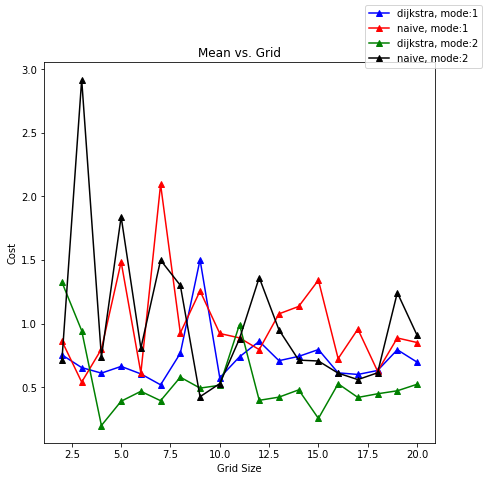

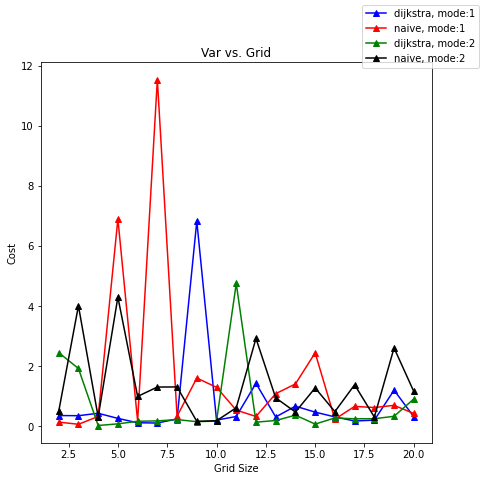

In [8]:
np.random.seed(30)
Game_analysis('grid',approach_eval=True, mode_eval=True, distr='lognormal')
print('%{} Increase in cost'.format(int((all_costs1[-1] - all_costs1[0])/ all_costs1[0])*100))
print('%{} Increase in cost'.format(int((all_costs2[-1] - all_costs2[0])/ all_costs2[0])*100))
print('%{} Increase in cost'.format(int((all_costs3[-1] - all_costs3[0])/ all_costs3[0])*100))
print('%{} Increase in cost'.format(int((all_costs4[-1] - all_costs4[0])/ all_costs4[0])*100))

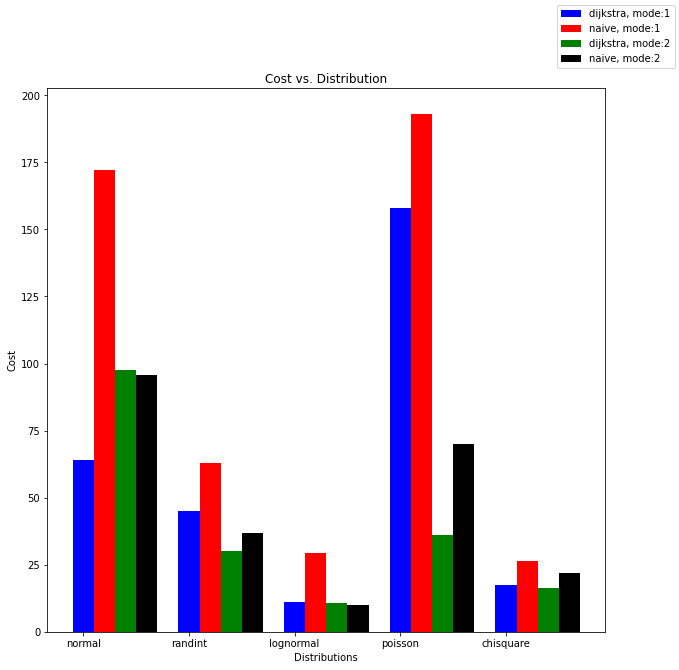

In [9]:
np.random.seed(42)
results = Game_analysis('distribution',True, True)

with initial parameters for each distribution we can see that poisson makes most cost for the game while lognormal has the lowest cost (since there are not big numbers in the cells).